In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Author's gender identification

## 0. Read dataset 

In [3]:
import xlrd

In [11]:
path = 'blog-gender-dataset.xlsx'

workbook = xlrd.open_workbook(path)
worksheet = workbook.sheet_by_index(0)

# Change this depending on how many header rows are present
# Set to 0 if you want to include the header data.
offset = 0

rows = []
for i, row in enumerate(range(worksheet.nrows)):
    if i <= offset:  # (Optionally) skip headers
        continue
    r = []
    for j, col in enumerate(range(worksheet.ncols)):
        r.append(worksheet.cell_value(i, j))
    rows.append(r[:2])

In [12]:
print('Got {} rows'.format(len(rows)))

Got 3231 rows


In [14]:
x_raw = []
y = []

for i in rows:
    x_raw.append(i[0])
    y.append(i[1])

# 1. Feature transform

In [16]:
import nltk
from nltk.corpus import stopwords
import pickle as pl
import re
import seaborn as sns

In [18]:
def word_features(text):
    raw_text =  re.split(' ',text)
    unwanted = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'
    raw_text2 = ''
    for k in raw_text:
        # Ignore urls
        if k.startswith('http') or k.startswith('http'):
            continue
        elif k.startswith('@'):     
            continue
        elif k.startswith('#'):
            continue
        else:
            raw_text2 += ' '
            raw_text2 += k
    words_raw = nltk.word_tokenize(raw_text2.lower())
    words = [w for w in words_raw if w not in unwanted]
    feat = {}
    for w in words:
        if w in feat.keys():
            feat[w] += 1
        else:
            feat[w] = 1
    return feat

In [25]:
# split to test and train

from random import shuffle
# Given list1 and list2
x_rand = []
y_rand = []
index_shuf = list(range(len(x_raw)))
shuffle(index_shuf)

for i in index_shuf:
    x_rand.append(x_raw[i])
    y_rand.append(y[i])

split_stamp = int(0.7 * len(x_rand))  
x_train = x_rand[:split_stamp]
y_train = y_rand[:split_stamp]

x_test = x_rand[split_stamp:]
y_test = y_rand[split_stamp:]

    

In [26]:
X = x_train
Y = y_train
train_set = []
prog = 0
for i in range(len(X)):
    train_set.append((word_features(X[i]), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 4 %
Finished 9 %
Finished 14 %
Finished 19 %
Finished 24 %
Finished 29 %
Finished 34 %
Finished 39 %
Finished 44 %
Finished 49 %
Finished 54 %
Finished 59 %
Finished 64 %
Finished 69 %
Finished 74 %
Finished 79 %
Finished 84 %
Finished 89 %
Finished 94 %
Finished 99 %


In [28]:
X = x_test
Y = y_test
test_set = []
prog = 0
for i in range(len(X)):
    test_set.append((word_features(X[i]), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 4 %
Finished 9 %
Finished 14 %
Finished 19 %
Finished 24 %
Finished 29 %
Finished 34 %
Finished 39 %
Finished 44 %
Finished 49 %
Finished 54 %
Finished 59 %
Finished 64 %
Finished 69 %
Finished 74 %
Finished 79 %
Finished 84 %
Finished 89 %
Finished 94 %
Finished 98 %


In [31]:
classif = 'nb'
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.05257731958762887


In [32]:
from random import choice

In [61]:
labels = ['M', 'F']
y_pred = [choice(labels) for i in range(len(test_set))]

In [62]:
y_test = list(map(lambda y: y[1],test_set))

In [63]:
import sklearn as sk

In [64]:
sk.metrics.accuracy_score(y_test, y_pred)

0.47216494845360824

In [33]:
def word2ngrams(text, n=3, exact=True):
    """ Convert sentence into character ngrams. """
    yield [text[i:i+n] for i in range(len(text)-n+1)]

In [31]:
def features(words, n=2):
    feat = {}
    for w in words:
        bi_grams = word2ngrams(w, n=n)
        for inst in bi_grams:
            for bg in inst:
                if bg in feat.keys():
                    feat[bg] +=  1
                else:
                    feat[bg] = 1

    return feat
    

In [29]:
def get_features(text, n_grams = 3, mode ='incl'):
    '''
     Transform sentence into feature vector 
     text: Sentence 
     n_grams: charachter ngram used
     mode: {'incl', None} If incl : Feature vector will conatin ngrams from 1 to n 
    '''
    raw_text =  re.split(' ',text)
    unwanted = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'
    raw_text2 = ''
    for k in raw_text:
        # Ignore urls
        if k.startswith('http') or k.startswith('http'):
            continue
        elif k.startswith('@'):     
            continue
        elif k.startswith('#'):
            continue
        else:
            raw_text2 += ' '
            raw_text2 += k
    words_raw = nltk.word_tokenize(raw_text2.lower())
    words = [w for w in words_raw if w not in unwanted]
    feat = word_features(text)
    feat.update(features(words, n=n_grams))
    #words_set = set(words)
    for lang in labels:
        feat[lang+'_stop'] = len(set(words).intersection(set(stopwords.words(lang))))
    if mode == 'incl':
        for i in range(1, n_grams):
            feat.update(features(words, n=i))
    elif mode == 'incl_except': 
         for i in range(2, n_grams):
            feat.update(features(words, n=i))
    return feat

In [2]:
def word_features(terms, inv_terms, text):
    raw_text =  re.split(' ',text)
    unwanted = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'
    raw_text2 = ''
    for k in raw_text:
        # Ignore urls
        if k.startswith('http') or k.startswith('http'):
            continue
        elif k.startswith('@'):     
            continue
        elif k.startswith('#'):
            continue
        else:
            raw_text2 += ' '
            raw_text2 += k
    words_raw = nltk.word_tokenize(raw_text2.lower())
    words = [w for w in words_raw if w not in unwanted]
    feat = {}
    for w in words:
        if w in feat.keys():
            feat[w] += 1
        else:
            feat[w] = 1
    return feat

In [72]:
def get_words(text):
    raw_text =  re.split(' ',text)
    unwanted = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~£'
    raw_text2 = ''
    for k in raw_text:
        # Ignore urls
        if k.startswith('http') or k.startswith('http'):
            continue
        elif k.startswith('@'):     
            continue
        elif k.startswith('#'):
            continue
        else:
            raw_text2 += ' '
            raw_text2 += k
    words_raw = nltk.word_tokenize(raw_text2.lower())
    words = [w for w in words_raw if w not in unwanted]
    return words

In [28]:
ngrams = 5
mode = 'incl'
stops = 'stop'

Finished 4 %
Finished 9 %
Finished 14 %
Finished 19 %
Finished 24 %
Finished 29 %
Finished 34 %
Finished 39 %
Finished 44 %
Finished 49 %
Finished 54 %
Finished 59 %
Finished 64 %
Finished 69 %
Finished 74 %
Finished 79 %
Finished 84 %
Finished 89 %
Finished 94 %
Finished 99 %


In [34]:
(X, Y) =  pl.load(open('langid.train', 'rb'))
train_set = []
prog = 0
for i in range(len(X)):
    train_set.append((get_features(X[i], n_grams=ngrams), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 4 %
Finished 9 %
Finished 14 %
Finished 19 %
Finished 24 %
Finished 29 %
Finished 34 %
Finished 39 %
Finished 44 %
Finished 49 %
Finished 54 %
Finished 59 %
Finished 64 %
Finished 69 %
Finished 74 %
Finished 79 %
Finished 84 %
Finished 89 %
Finished 94 %
Finished 99 %


In [9]:
(X, Y) =  pl.load(open('langid.test', 'rb'))
test_set = []
prog = 0
for i in range(len(X)):
    test_set.append((word_features(X[i]), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 5 %
Finished 10 %
Finished 15 %
Finished 20 %
Finished 25 %
Finished 30 %
Finished 35 %
Finished 40 %
Finished 45 %
Finished 50 %
Finished 55 %
Finished 60 %
Finished 65 %
Finished 70 %
Finished 75 %
Finished 80 %
Finished 85 %
Finished 90 %
Finished 95 %
Finished 100 %


In [35]:
(X, Y) =  pl.load(open('langid.test', 'rb'))
test_set = []
prog = 0
for i in range(len(X)):
    test_set.append((get_features(X[i], n_grams=ngrams), Y[i]))
    prog += 1
    if prog%(len(X)//20) == 0:
        print("Finished " + str(100*prog//len(X)) + ' %')

Finished 5 %
Finished 10 %
Finished 15 %
Finished 20 %
Finished 25 %
Finished 30 %
Finished 35 %
Finished 40 %
Finished 45 %
Finished 50 %
Finished 55 %
Finished 60 %
Finished 65 %
Finished 70 %
Finished 75 %
Finished 80 %
Finished 85 %
Finished 90 %
Finished 95 %
Finished 100 %


# 2. Train and classify

In [10]:
classif = 'nb'
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.9232558139534883


In [36]:
classif = 'nb'
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.9418604651162791


In [66]:
classifier = nltk.DecisionTreeClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.4690721649484536


In [22]:
ngrams = 'word'
stops = 'stop'
mode = 'def'

In [37]:
import collections
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)
 
true_lab = []
pred_lab = []
for i,(feats, label) in enumerate(test_set):
    true_lab.append(label)
    refsets[label].add(i)
    observed = classifier.classify(feats)
    pred_lab.append(observed)
    testsets[observed].add(i)
labels = list(refsets.keys())

In [67]:
k_list = classifier.show_most_informative_features(20)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'show_most_informative_features'

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.grid_search import GridSearchCV

In [73]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=get_words)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('nb', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [77]:
%%time
pipeline.fit(x_train, y_train)

CPU times: user 9.62 s, sys: 80.9 ms, total: 9.7 s
Wall time: 9.74 s


Pipeline(steps=[('bow', CountVectorizer(analyzer=<function get_words at 0x10ee89b70>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
  ...linear_tf=False, use_idf=True)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [82]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=get_words)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('nb', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {
    'nb__alpha':[0.1,0.6,0.7,0.8,0.9,1.0]
}


clf = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()

print("Best score: %0.3f" % clf.best_score_)

/usr/local/lib/python3.4/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


Best parameters set found on development set:

{'nb__alpha': 0.6}

Best score: 0.655


In [84]:
clf.score(x_test, y_test)

0.64639175257731962

In [95]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

CountVectorizer(analyzer=<function get_words at 0x10ee89b70>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [100]:
print_top10(clf.get_params()['estimator__bow'], clf, ['M', "F"])

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

In [ ]:
pipeline.get_params()['bow']

In [78]:
pipeline.score(x_test, y_test)

0.64845360824742271

In [108]:
word_vectorizer = CountVectorizer(analyzer='word')
trainset = word_vectorizer.fit_transform(x_train)
tft = TfidfTransformer()
train_set = tft.fit_transform(trainset)

# Training NB
mnb = MultinomialNB()
mnb.fit(train_set, y_train)


def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print(classlabel, feat, coef)

In [110]:
most_informative_feature_for_class(word_vectorizer, mnb, 'M')

M for -7.12487028303
M you -7.03895185849
M it -6.93077051968
M is -6.88162178044
M that -6.8739261955
M in -6.74654817119
M of -6.48145412649
M and -6.34313109668
M to -6.28840671156
M the -5.79018172453


In [111]:
most_informative_feature_for_class(word_vectorizer, mnb, 'F')

F you -7.10100506333
F is -7.0642222359
F that -6.92123640747
F in -6.89021146953
F it -6.82834960768
F my -6.75550713477
F of -6.64731833904
F and -6.29373017393
F to -6.26563482529
F the -6.00788656587


In [68]:
from sklearn.naive_bayes import MultinomialNB
X = []
Y = []
for (x,y) in train_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf = MultinomialNB()
clf.fit(X, Y)

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: setting an array element with a sequence.

In [852]:
X = []
Y = []
for (x,y) in test_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.score(X, Y)

0.92848837209302326

In [853]:
from sklearn.svm import SVC
X = []
Y = []
for (x,y) in train_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)

clf = SVC(kernel = 'rbf')
clf.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [854]:
X = []
Y = []
for (x,y) in test_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.score(X, Y)

0.90930232558139534

In [747]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [858]:

clf = rfc(n_jobs=-1, n_estimators=317, max_depth=None)
X = []
Y = []
for (x,y) in train_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.fit(X, Y)

X = []
Y = []
for (x,y) in test_set:
    temp = []
    for x1 in x.values():
        temp.append(x1)
    X.append(temp)
    Y.append(y)
    
clf.score(X, Y)


0.92209302325581399

In [863]:
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)
 
true_lab = []
pred_lab = []
indx = 0
for i in range(len(X)):
    true_lab.append(Y[i])
    refsets[Y[i]].add(indx)
    observed = clf.predict(X[i])
    pred_lab.append(observed)
    testsets[observed[0]].add(indx)
    indx += 1

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local

Normalized confusion matrix


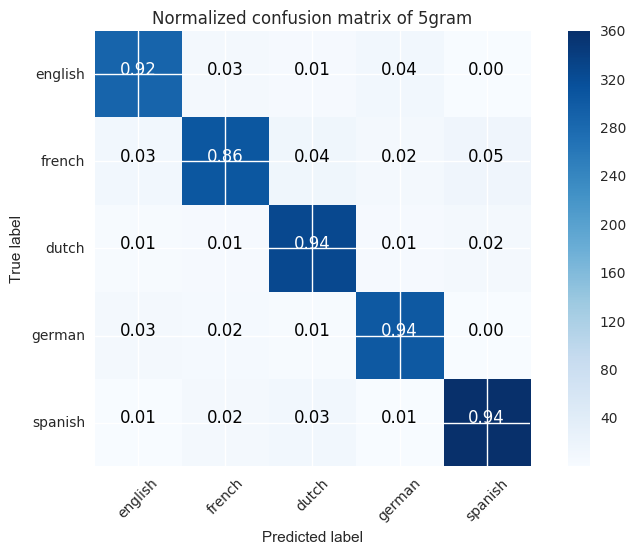

In [860]:

  
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(pred_lab, true_lab)
np.set_printoptions(precision=2)



# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix of {}gram'.format(ngrams))
fig = plt.Figure()
fig.set_canvas(plt.gcf().canvas)
fig.savefig('{}{}{}gram_cm_{}{}.png'.format(stops,mode,ngrams, classif, n_feat))

plt.show()

F-score: for  english   0.8911465892597967
F-score: for  french   0.9261363636363636
F-score: for  dutch   0.9201277955271565
F-score: for  german   0.9339477726574501
F-score: for  spanish   0.9376623376623376


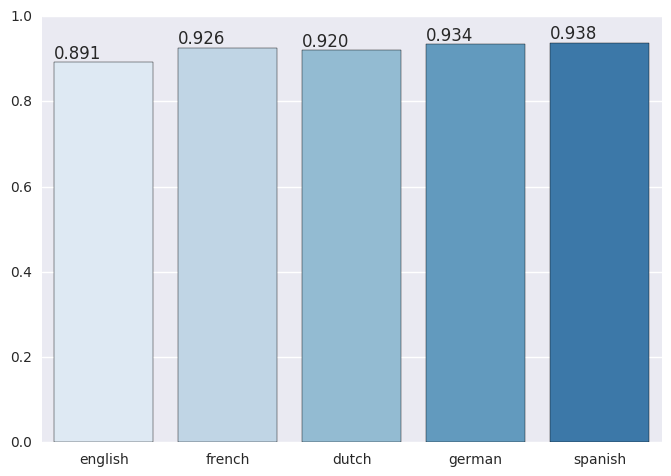

In [867]:
labels = list(refsets.keys())
res = []
for lab in labels:
    print('F-score: for ', lab, ' ' , nltk.f_measure(refsets[lab], testsets[lab]))
    res.append(nltk.f_measure(refsets[lab], testsets[lab]))
x= labels
y = res

ax = sns.barplot(x, y, palette=sns.color_palette("Blues"))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height + 0.01, '%1.3f'%(height))
show()
fig1 = ax.get_figure()
fig1.savefig('{}{}{}gram_fs_{}{}.png'.format(stops,mode,ngrams,classif,n_feat))

